Original source for majority of the code below is d2l.ai, but some codes are modified to make them fit better to the class contents and be independent of the d2l library for better understanding of the coding principles.

Dr. Ulya Bayram

In [0]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plt.figure(figsize=(6, 4))
    plt.plot(f_line, [f(x) for x in f_line], '-', label='f(x)')
    plt.plot(results, [f(x) for x in results], 'x', label='f(x)', linestyle='None')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()

In [9]:
#@ save
def train_2d(trainer, steps=20, f_grad=None):  
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    plt.figure(figsize=(6, 4))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1), torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# Momentum

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

As before $f$ has its minimum at $(0, 0)$. This function is *very* flat in the direction of $x_1$. Let's see what happens when we perform gradient descent as before on this new function. We pick a learning rate of $0.4$.

epoch 20, x1: -0.943467, x2: -0.000073
/shared-libs/python3.9/py/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


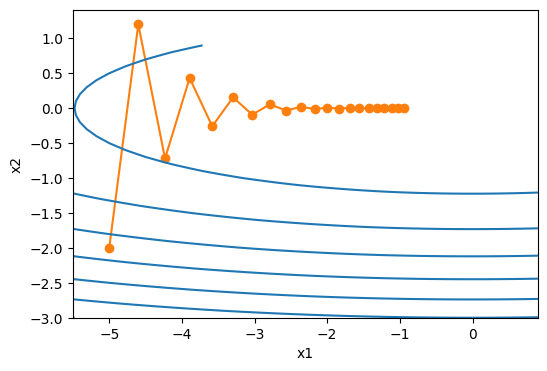

In [10]:
# With standard gradient descent

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

The gradient in the $x_2$ direction is *much* higher and changes much more rapidly than in the horizontal $x_1$ direction. 

Thus we are stuck between two undesirable choices: 
- if we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. 

- conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$. 

The example below illustrates what happens even after a slight increase in learning rate from $0.4$ to $0.6$.

epoch 20, x1: -0.387814, x2: -1673.365109


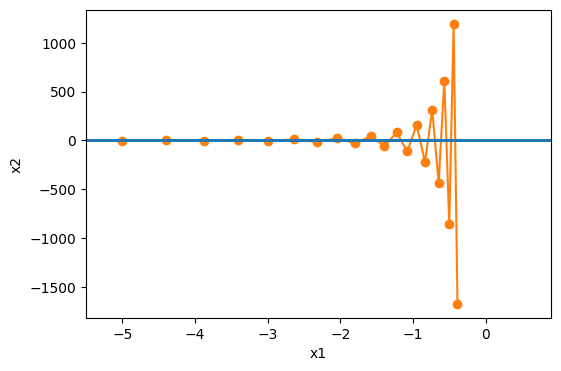

In [12]:
# With standard gradient descent

eta = 0.6

show_trace_2d(f_2d, train_2d(gd_2d))

Averaging gradients over the past would work well. 

After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. 

Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.

Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

epoch 20, x1: 0.007188, x2: 0.002553


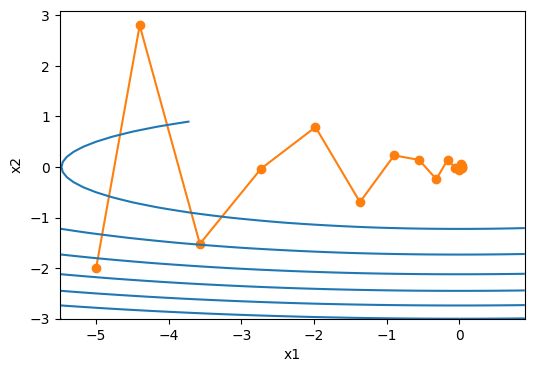

In [16]:
# without gt
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


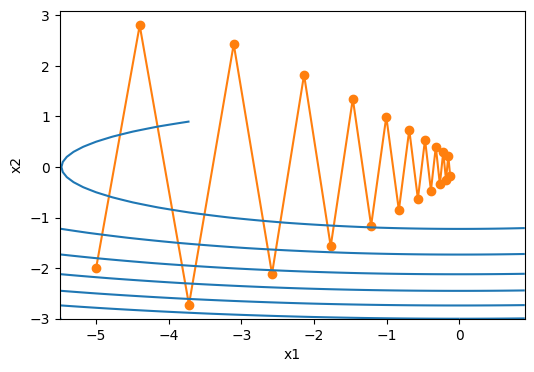

In [17]:
# Daha az momentum?

eta, beta = 0.6, 0.25
show_trace_2d(f_2d, train_2d(momentum_2d))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=700e962d-3fcf-4c82-8c8d-f1f2cc26fdf7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>